In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
from torchvision import datasets
from torchvision import transforms

data_path = './data/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_validation = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.ToTensor())

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=train_transform)

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=validation_transform)
# cifar10_val_train = datasets.CIFAR10(data_path, train=True, download=True, transform=validation_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import torch.nn.functional as F

class ResBlockPlain(nn.Module):
    def __init__(self, input_channels, channel_factor=1, stride=1):
        super().__init__()
        self.channel_factor = channel_factor
        self.stride = stride

        out_channels = input_channels * channel_factor
        self.conv1 = nn.Conv2d(
            input_channels,
            out_channels,
            kernel_size=3, padding=1, stride=stride,
            bias=False
        )
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3, padding=1, stride=1,
            bias=False
        )
        self.batch2 = nn.BatchNorm2d(out_channels)

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        #     elif isinstance(m, nn.BatchNorm2d):
        #         nn.init.constant_(m.weight, 1)
        #         nn.init.constant_(m.bias, 0)

        # if stride != 1:
        #     self.downsample = nn.MaxPool2d(stride,stride)
        self.shortcut = nn.Sequential()
        if channel_factor != 1 or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, input_channels * channel_factor, kernel_size=1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(input_channels * channel_factor)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.batch1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.batch2(out)
        # if self.stride != 1 or self.channel_factor != 1:
        # #     x = self.downsample(x)
        # # if self.channel_factor != 1:
        #     x = self.cut(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    # def shortcut(self, input_channels, output_channels, stride):
    #     return nn.Conv2d(input_channels, output_channels, kernel_size=1, padding=0, stride=stride, bias=False)


class NetResDeep(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool1 = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.resblocksm1 = nn.Sequential(
            *[ResBlockPlain(64) for _ in range(2)]
        )
        self.resblocks0 = ResBlockPlain(64, 2, stride=2)
        self.resblocks1 = nn.Sequential(
            *[ResBlockPlain(128) for _ in range(1)]
        )
        self.resblocks2 = ResBlockPlain(128, 2, stride=2)
        self.resblocks3 = nn.Sequential(
            *[ResBlockPlain(256, 1) for _ in range(1)]
        )
        self.resblocks4 = ResBlockPlain(256, 2, stride=2)
        self.resblocks5 = nn.Sequential(
            *[ResBlockPlain(512, 1) for _ in range(1)]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        # out = self.pool1(out)
        # out = F.max_pool2d(out, 2)
        out = self.resblocksm1(out)
        out = self.resblocks0(out)
        out = self.resblocks1(out)
        out = self.resblocks2(out)
        out = self.resblocks3(out)
        out = self.resblocks4(out)
        out = self.resblocks5(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.fc(out)
        return out

In [6]:
NetResDeep()

NetResDeep(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resblocksm1): Sequential(
    (0): ResBlockPlain(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlockPlain(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblocks0): ResBlockPlain(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


In [6]:
device = (torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu"))
device

device(type='cuda', index=0)

In [7]:
import datetime

def training_loop(n_epochs: int, optimizer, scheduler, model, loss_fn, train_loader, validate_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        scheduler.step()

        if epoch == 1 or epoch % 10 == 0:
            train_acc, test_acc = validate(model, train_loader, validate_loader)
            print(f"{datetime.datetime.now()} {epoch}/{n_epochs}: loss {loss_train / len(train_loader):.4f}, acc = ({train_acc:.3f},{test_acc:.3f})")

def validate(model, train_loader, validate_loader):
    model.eval()
    result = []
    for name, loader in [("train", train_loader), ("val", validate_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels
                # outputs = validate_tta(imgs, tta_layer, model, size=9).cpu()
                outputs = model(imgs).cpu()
                predicted = np.argmax(outputs.numpy(), axis=1)
                total += labels.shape[0]

                correct += int((predicted == labels.numpy()).sum())

            result.append(correct / total)
            # print(f"{name} acc: {correct / total:.3f}")
    model.train()
    return tuple(result)

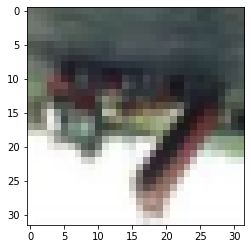

In [67]:
img, _ = cifar10_expanded[2]
img = img.permute(1,2,0)
#print(img.shape)
#print(img)
plt.imshow(img)
plt.show()

In [20]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=16, shuffle=True)
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)
    print(labels)
    break

torch.Size([16, 3, 32, 32]) torch.Size([16])
tensor([4, 5, 5, 7, 8, 5, 0, 2, 7, 7, 2, 1, 7, 3, 2, 8])


In [8]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True)
validate_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=128, shuffle=False)
model = NetResDeep()
# model.load_state_dict(torch.load(data_path + "cifar10_2.pt"))
# model = torch.nn.DataParallel(model, device_ids=[0,1])
# model.load_state_dict(torch.load(data_path + "cifar10.pt"))
model = model.to(device=device)

print(device)
# model = model.to(device)
# model = Net().to(device=device)
# optimizer = optim.Adam(model.parameters(), lr=1e-6)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

training_loop(
    n_epochs=140,
    optimizer=optimizer,
    scheduler=scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    validate_loader=validate_loader
)

torch.save(model.state_dict(), data_path + "cifar10.pt")

cuda:0
2022-05-20 09:28:48.164180 1/140: loss 1.8458, acc = (0.406,0.432)
2022-05-20 09:33:14.285354 10/140: loss 0.4919, acc = (0.798,0.789)
2022-05-20 09:38:08.853258 20/140: loss 0.3830, acc = (0.853,0.834)
2022-05-20 09:43:05.044361 30/140: loss 0.3426, acc = (0.829,0.808)
2022-05-20 09:48:00.156343 40/140: loss 0.3238, acc = (0.863,0.844)
2022-05-20 09:52:59.810683 50/140: loss 0.2958, acc = (0.844,0.822)
2022-05-20 09:57:53.766002 60/140: loss 0.2800, acc = (0.897,0.871)
2022-05-20 10:02:47.729432 70/140: loss 0.2623, acc = (0.907,0.880)
2022-05-20 10:07:41.922167 80/140: loss 0.2398, acc = (0.903,0.869)
2022-05-20 10:12:37.905123 90/140: loss 0.2177, acc = (0.906,0.879)
2022-05-20 10:17:31.838376 100/140: loss 0.1934, acc = (0.936,0.899)
2022-05-20 10:22:26.724729 110/140: loss 0.1621, acc = (0.939,0.902)
2022-05-20 10:27:21.018228 120/140: loss 0.1347, acc = (0.940,0.896)
2022-05-20 10:32:14.876872 130/140: loss 0.1103, acc = (0.966,0.920)
2022-05-20 10:37:10.043448 140/140: lo

In [35]:
pretrained_dict = loaded_model.state_dict()
pretrained_dict = {key.replace("module.", ""): value for key, value in pretrained_dict.items()}
m_model = NetResDeep().to(device=device)
m_model.load_state_dict(pretrained_dict)
torch.save(m_model.state_dict(), data_path + "cifar10_mm.pt")

In [48]:
loaded_model = NetResDeep().to(device=device)
loaded_model = torch.nn.DataParallel(loaded_model, device_ids=[0,1,2])
loaded_model.load_state_dict(torch.load(data_path + "cifar10.pt"))
loaded_model.eval()

DataParallel(
  (module): NetResDeep(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resblocksm1): Sequential(
      (0): ResBlockPlain(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResBlockPlain(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (resblocks0): ResBlockPlain(
      (conv1): Conv2d(

In [60]:
def validate_tta(imgs, tta_layer, model, size=9):
    # imgs -> N, C, H, W
    augmented = torch.vstack([*[tta_layer(imgs) for _ in range(size-1)], imgs])
    # augmented -> 9, N, C, H, W -> 9*N, C, H, W
    augmented = augmented.view(-1, imgs.shape[1], imgs.shape[2], imgs.shape[3])
    predicted = model(augmented.to(device=device))
    predicted = predicted.view(size, imgs.shape[0], 10)
    return torch.sum(predicted, 0)


img, l = cifar10[9]
# plt.imshow(img.permute(1,2,0))
# plt.show()
# predicted = loaded_model(img.unsqueeze(0).to(device=device))

tta_layer = nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(20, translate=(0.1,0.1), scale=(0.9, 1.1)),
)

loaded_model.eval()
predicted = validate_tta(img.unsqueeze(0), tta_layer, loaded_model)
loaded_model.train()
print(predicted, l)

tensor([[ -14.9913,  -53.5412, -114.9717,   32.8586,  -42.5173,   26.1958,
          -59.7509, -132.1227,  -20.0103,  -10.1331]], device='cuda:0',
       grad_fn=<SumBackward1>) 3


In [61]:
train_loader = torch.utils.data.DataLoader(cifar10_val_train, batch_size=256, shuffle=False)
validate_loader = torch.utils.data.DataLoader(cifar10_validation, batch_size=1024, shuffle=False)

def validate(model, train_loader, validate_loader):
    model.eval()
    for name, loader in [("train", train_loader), ("val", validate_loader)]:
        if loader is None:
            continue
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels
                if name == "val":
                    outputs = validate_tta(imgs, tta_layer, model, size=9).cpu()
                else:
                    outputs = model(imgs).cpu()
                predicted = np.argmax(outputs.numpy(), axis=1)
                total += labels.shape[0]

                correct += int((predicted == labels.numpy()).sum())

            print(f"{name} acc: {correct / total:.3f}")
    model.train()

# def validate(model, train_loader, validate_loader):
#     model.eval()
#     result = []
#     for name, loader in [("train", train_loader), ("val", validate_loader)]:
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for imgs, labels in loader:
#                 imgs = imgs.to(device=device)
#                 labels = labels
#                 outputs = model(imgs).cpu()
#                 predicted = np.argmax(outputs.numpy(), axis=1)
#                 total += labels.shape[0]

#                 correct += int((predicted == labels.numpy()).sum())

#             result.append(correct / total)
#             # print(f"{name} acc: {correct / total:.3f}")
#     model.train()
#     return tuple(result)

validate(loaded_model, train_loader, validate_loader)

train acc: 0.986
val acc: 0.876


In [14]:
import datetime

def training_loop(n_epochs: int, optimizer, scheduler, model, loss_fn, train_loader, validate_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        scheduler.step()

        if epoch == 1 or epoch % 5 == 0:
            train_acc, test_acc = validate(model, train_loader, validate_loader)
            print(f"{datetime.datetime.now()} {epoch}/{n_epochs}: loss {loss_train / len(train_loader):.4f}, acc = ({train_acc:.3f},{test_acc:.3f})")

def validate(model, train_loader, validate_loader):
    model.eval()
    result = []
    for name, loader in [("train", train_loader), ("val", validate_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels
                outputs = model(imgs).cpu()
                predicted = np.argmax(outputs.numpy(), axis=1)
                total += labels.shape[0]

                correct += int((predicted == labels.numpy()).sum())

            result.append(correct / total)
            # print(f"{name} acc: {correct / total:.3f}")
    model.train()
    return tuple(result)